In [2]:
import pandas as pd
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

import time


In [55]:
songs = pd.read_csv('reduced_dataset.csv').replace('"','', regex=True)

In [56]:
songs

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010
...,...,...,...,...
9994,c50566d83fba17b20697039d5824db78,Marilyn Manson,The Speed Of Pain,Everything at once
9995,c50566d83fba17b20697039d5824db78,Voxtrot,The Start of Something,Everything at once
9996,c50566d83fba17b20697039d5824db78,Marina and The Diamonds,The State Of Dreaming,Everything at once
9997,c50566d83fba17b20697039d5824db78,The Duke Spirit,The Step And The Walk,Everything at once


In [57]:
songs.info()
df = songs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9999 non-null   object
 1   artistname    9991 non-null   object
 2   trackname     9999 non-null   object
 3   playlistname  9998 non-null   object
dtypes: object(4)
memory usage: 312.6+ KB


In [58]:
df[df.isnull().any(axis=1)]

,user_id,artistname,trackname,playlistname
769,07f0fc3be95dcd878966b1f9572ff670,NaN,07 - echoes,Starred
2606,c5cdf06b5f1836006ef2a2fe4f5ff103,NaN,Im Not Okay (I Promise) ~ My Chemical Romance,ngt emo eller
2607,c5cdf06b5f1836006ef2a2fe4f5ff103,NaN,Just The Girl - The Click Five Cover,ngt emo eller
2608,c5cdf06b5f1836006ef2a2fe4f5ff103,NaN,Low - Sleeping With Sirens Cover,ngt emo eller
2609,c5cdf06b5f1836006ef2a2fe4f5ff103,NaN,Pierce The Veil - -Just The Way You Are- Lyric...,ngt emo eller
2610,c5cdf06b5f1836006ef2a2fe4f5ff103,NaN,Pierce The Veil - Disasterology ( Lyrics ),ngt emo eller
2612,c5cdf06b5f1836006ef2a2fe4f5ff103,NaN,live and let die- paul mccartney,ngt emo eller
2613,c5cdf06b5f1836006ef2a2fe4f5ff103,NaN,patty walters - My Chemical Romance 'TEENAGERS...,ngt emo eller
8621,c50566d83fba17b20697039d5824db78,SNAP!,"Rhythm Is A Dancer - Original 12,Everything at...",NaN


In [59]:
list(df)


['user_id', 'artistname', 'trackname', 'playlistname']

In [60]:
for i in list(df):
    df = df[df[i].notna()]

In [61]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9990 entries, 0 to 9998
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9990 non-null   object
 1   artistname    9990 non-null   object
 2   trackname     9990 non-null   object
 3   playlistname  9990 non-null   object
dtypes: object(4)
memory usage: 390.2+ KB


In [62]:
df

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010
...,...,...,...,...
9994,c50566d83fba17b20697039d5824db78,Marilyn Manson,The Speed Of Pain,Everything at once
9995,c50566d83fba17b20697039d5824db78,Voxtrot,The Start of Something,Everything at once
9996,c50566d83fba17b20697039d5824db78,Marina and The Diamonds,The State Of Dreaming,Everything at once
9997,c50566d83fba17b20697039d5824db78,The Duke Spirit,The Step And The Walk,Everything at once


In [71]:
graph = defaultdict(list)
lista = [df.query(f'trackname=="{item}"')['playlistname'].iloc[0] for item in df.trackname]
un = set(lista)
len(un)

38

In [70]:
o = [1,2,3]
o

[1, 2, 3]

In [4]:
test_graph = {
    
    'Irreplaceable': ['rnb', 'pop', 'beyoince', 'female vocalist', 'soul'],
    'I Kissed a Girl': ['pop','female vocalist','katy perry','pop rock'],
    'Toxic': ['pop','dance','britney spears','female vocalists', 'sexy'],
    'SexyBack': ['pop','dance','sexy','rnb','justin timberlake'],
    
}

for node in list(test_graph.keys()):
    for edge in test_graph[node]:
        if edge in test_graph:
            test_graph[edge].append(node)
        else:
            test_graph[edge] = [node]
test_graph.keys()

dict_keys(['Irreplaceable', 'I Kissed a Girl', 'Toxic', 'SexyBack', 'rnb', 'pop', 'beyoince', 'female vocalist', 'soul', 'katy perry', 'pop rock', 'dance', 'britney spears', 'female vocalists', 'sexy', 'justin timberlake'])

In [5]:
_graph = nx.Graph()

_graph.add_nodes_from(list(test_graph.keys()))

for node in list(test_graph.keys()):
    for edge in test_graph[node]:
        _graph.add_edge(node,edge)

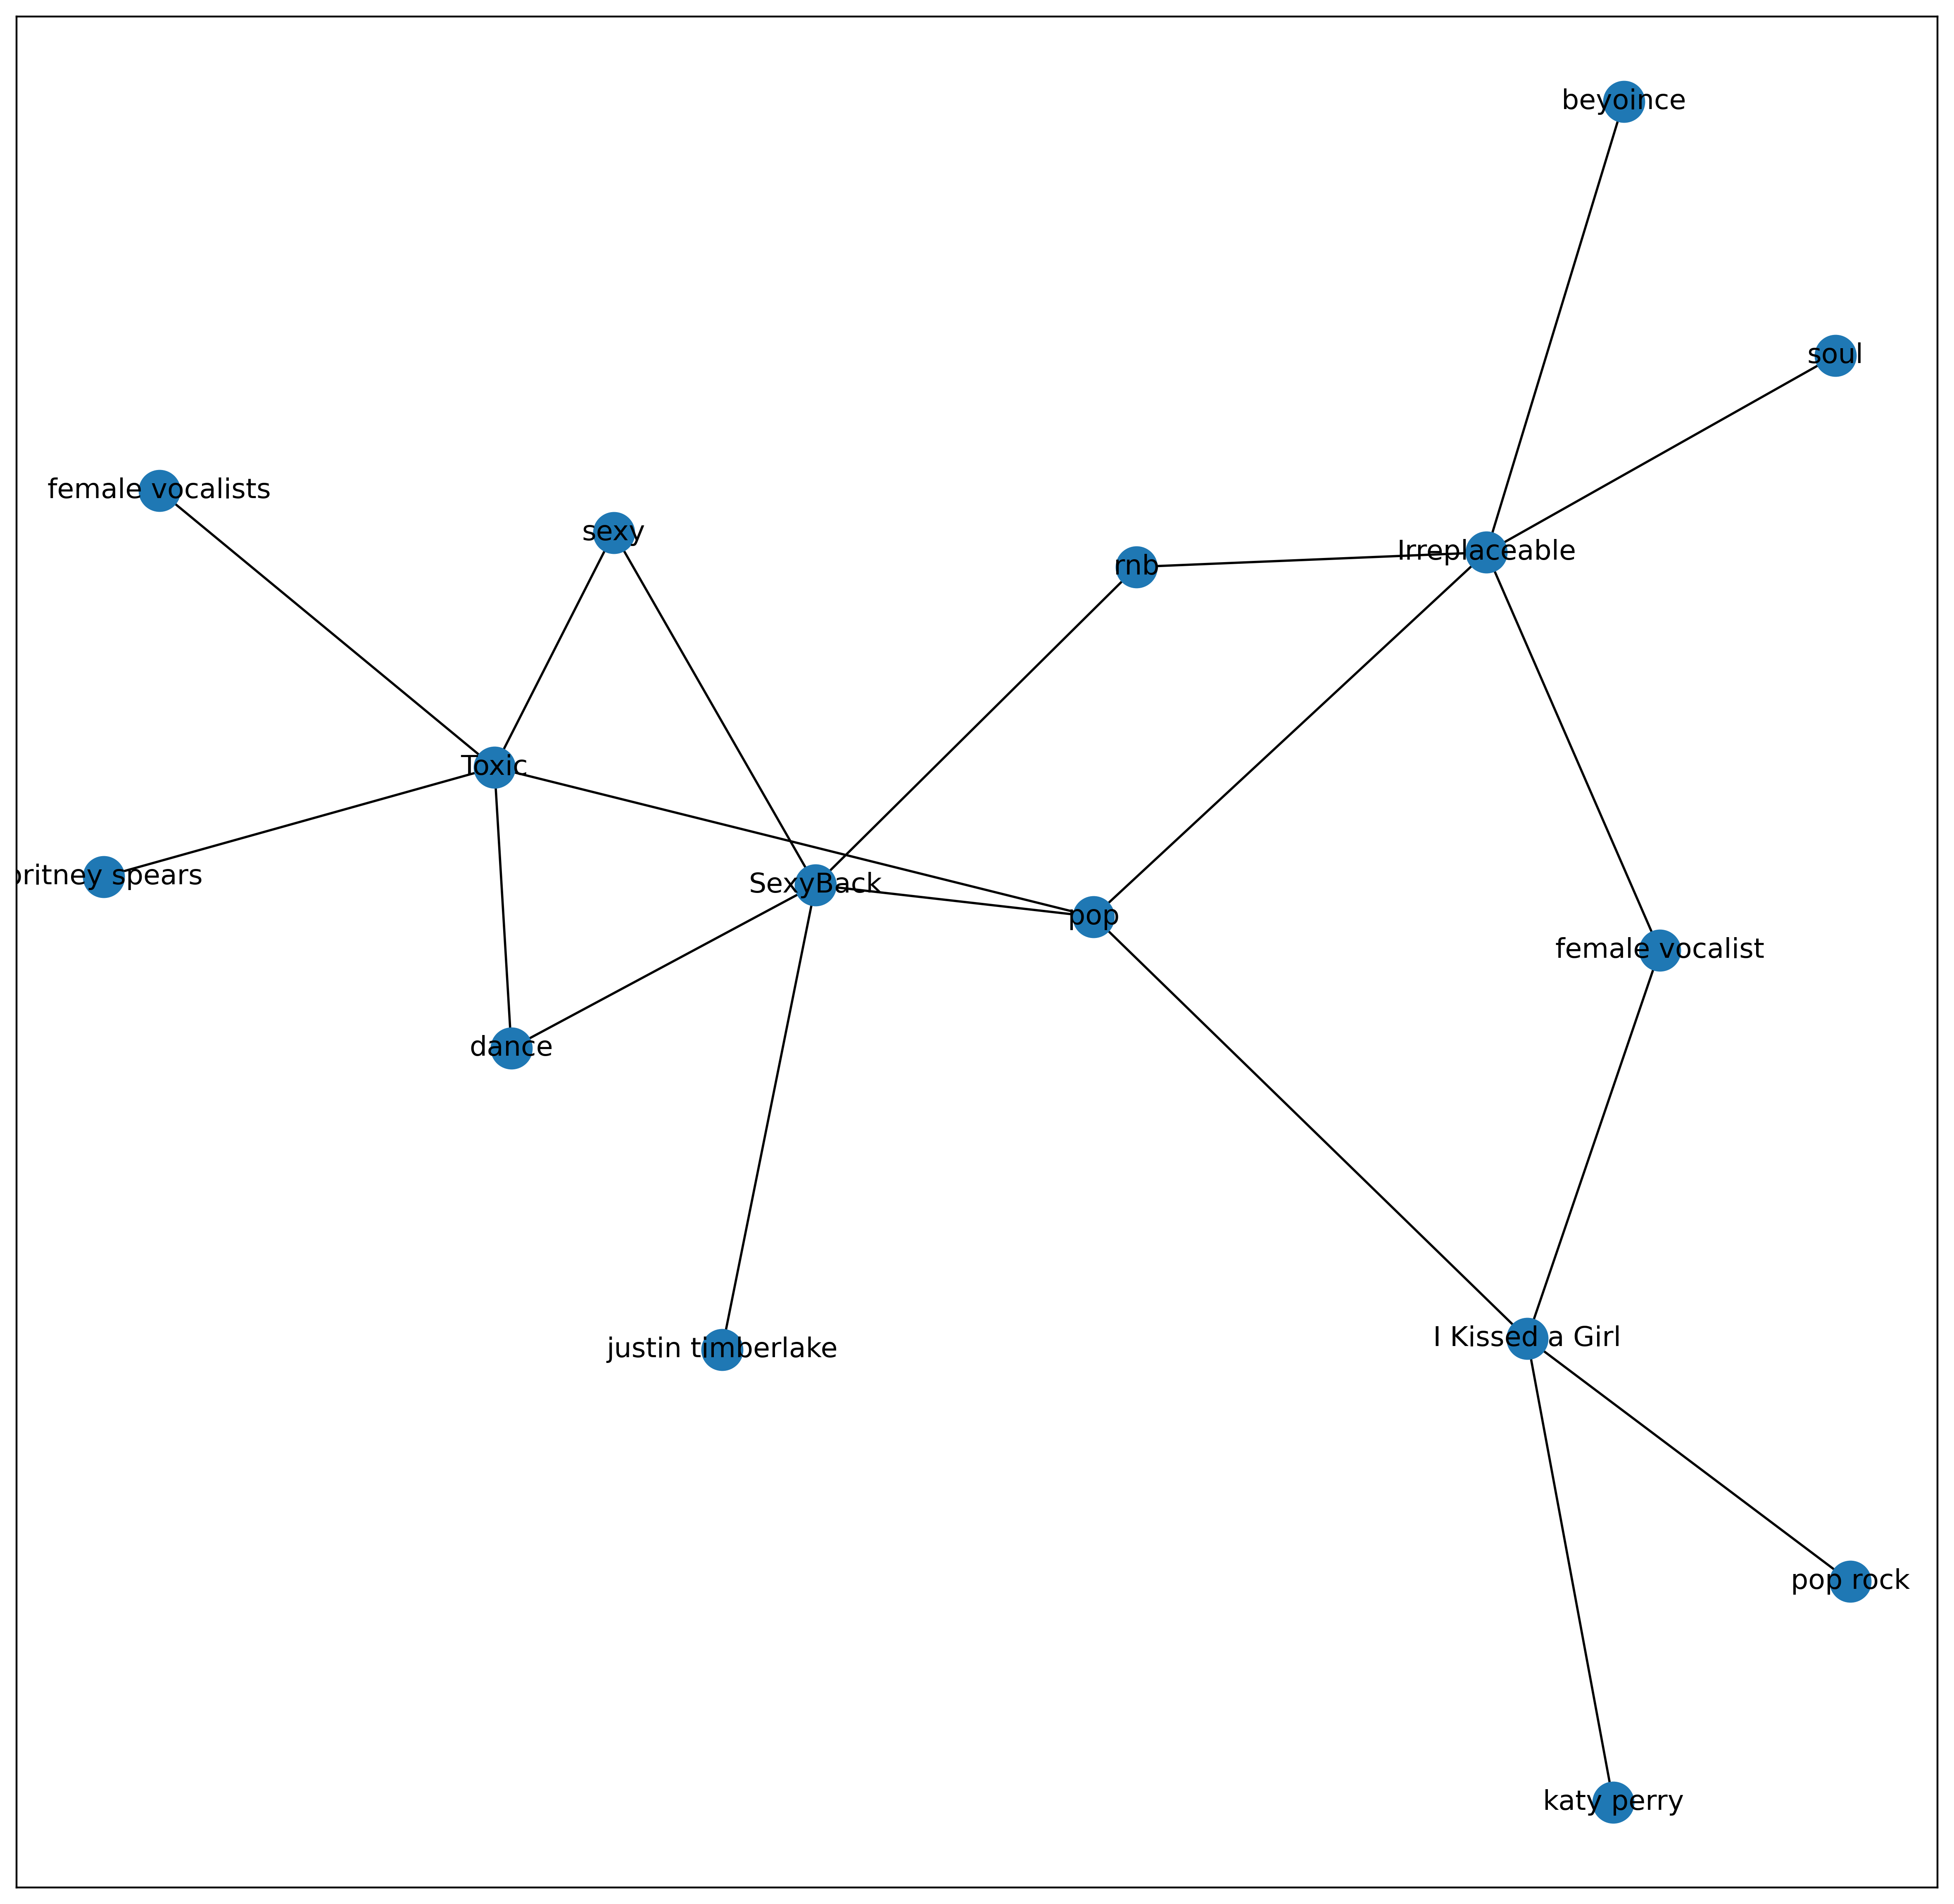

In [66]:

plt.figure(num=1,figsize=(15,15),dpi=400)
plt.rcParams.update({'font.size': 44})

nx.draw_networkx(_graph)
plt.show()

In [6]:
%%time
visited = defaultdict()
def backtrace(parent, start, end):
    path = [end]
    while path[-1] != start:
        path.append(parent[path[-1]])
    path.reverse()
    return path

def bfs(graph, start, end):
    parent = {}
    queue = []
    visited[start] = True
    queue.append(start)
    while queue:
        node = queue.pop(0)
        if node == end:
            return backtrace(parent, start, end)
        for adjacent in graph.get(node, []):
                if adjacent not in visited.keys():
                    if node not in queue :
                        parent[adjacent] = node # <<<<< record its parent 
                        queue.append(adjacent)
                        visited[adjacent] = True

recommended = bfs(test_graph, 'Toxic', 'I Kissed a Girl')
print(recommended)

['Toxic', 'pop', 'I Kissed a Girl']
CPU times: user 312 µs, sys: 244 µs, total: 556 µs
Wall time: 396 µs


In [80]:
%%time

visited = [] # List to keep track of visited nodes.
queue = []     #Initialize a queue

def bfs(visited, graph, node):
  visited.append(node)
  queue.append(node)

  while queue:
    s = queue.pop(0) 
    print (s, end = " ") 

    for neighbour in graph[s]:
      if neighbour not in visited:
        visited.append(neighbour)
        queue.append(neighbour)

# Driver Code
bfs(visited, test_graph, 'Toxic')


Toxic pop dance britney spears female vocalists sexy Irreplaceable I Kissed a Girl SexyBack rnb beyoince female vocalist soul katy perry pop rock justin timberlake CPU times: user 0 ns, sys: 9.99 ms, total: 9.99 ms
Wall time: 5.32 ms


In [9]:
%%time
# finds shortest path between 2 nodes of a graph using BFS
def bfs_shortest_path(graph, start, goal):
    # keep track of explored nodes
    explored = []
    # keep track of all the paths to be checked
    queue = [[start]]
 
    # return path if start is goal
    if start == goal:
        return "That was easy! Start = goal"
 
    # keeps looping until all possible paths have been checked
    while queue:
        # pop the first path from the queue
        path = queue.pop(0)
        # get the last node from the path
        node = path[-1]
        if node not in explored:
            neighbours = graph[node]
            # go through all neighbour nodes, construct a new path and
            # push it into the queue
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)
                # return path if neighbour is goal
                if neighbour == goal:
                    return new_path
 
            # mark node as explored
            explored.append(node)
 
    # in case there's no path between the 2 nodes
    return "So sorry, but a connecting path doesn't exist :("
 
bfs_shortest_path(test_graph, 'SexyBack', 'I Kissed a Girl')  # returns ['G', 'C', 'A', 'B', 'D']


CPU times: user 21 µs, sys: 16 µs, total: 37 µs
Wall time: 42.2 µs


['SexyBack', 'pop', 'I Kissed a Girl']

In [76]:
def bfs_connected_component(graph, start):
    # keep track of all visited nodes
    explored = []
    # keep track of nodes to be checked
    queue = [start]
 
    # keep looping until there are nodes still to be checked
    while queue:
        # pop shallowest node (first node) from queue
        node = queue.pop(0)
        if node not in explored:
            # add node to list of checked nodes
            explored.append(node)
            neighbours = graph[node]
 
            # add neighbours of node to queue
            for neighbour in neighbours:
                queue.append(neighbour)
    return explored
 
bfs_connected_component(test_graph,'Toxic')


0.0024187564849853516